# importing Libraries

In [1]:
import re                             # Regular expressions to process text
import numpy as np                    # Package for array operations
import zipfile                        # So we can unzip a zip file/
from random import shuffle            # To shuffle the data
from matplotlib import pyplot as plt  # Package for plotting data
from google.colab import drive        # So we can read files from our Google Drive
from glob import glob                 # So we can get filenames
from pandas import DataFrame as DF    # So we can manipulate "spreadsheets"
import cv2                            # so we can read images
from sklearn.decomposition import IncrementalPCA      #to apply incremental PCA on data
from sklearn import preprocessing                     #to normalize data

# Reading dataset and Mounting on Colab

In [2]:
!pip install gdown

In [3]:
!gdown "https://drive.google.com/uc?id=1soToY0PTngPRnRo5DCFZveVGwZsPCmX-"

Downloading...
From: https://drive.google.com/uc?id=1soToY0PTngPRnRo5DCFZveVGwZsPCmX-
To: /content/UTKFace.tar
138MB [00:01, 101MB/s] 


In [4]:
!tar -xf UTKFace.tar #unzip data

In [5]:
image_filenames = glob('./UTKFace/*.jpg') #read all directories which are our data(images)
print(len(image_filenames))

23708


In [6]:
image_filenames[0]

'./UTKFace/26_0_1_20170113135238738.jpg.chip.jpg'

In [7]:
shuffle(image_filenames) #shuffle data

In [8]:
image_filenames[0]

'./UTKFace/55_0_0_20170120221715677.jpg.chip.jpg'

seperate path, age, gender and race for each image from image's path by using regex (use part of this [code](https://colab.research.google.com/drive/1EGLzda6w6vK4bdZa6EKFg_512RZ5Xk6r#scrollTo=8C_hTzVTV_2o&line=1&uniqifier=1))

In [9]:
import re
regex_name = '.*/(\d+)_(\d+)_(\d+)_.*.jpg'
matches = [re.match(regex_name, f) for f in image_filenames]
labels = DF([[m[i] for i in range(4)] for m in matches if m], columns=['path', 'age', 'gender', 'race'])


In [10]:
labels

,path,age,gender,race
0,./UTKFace/55_0_0_20170120221715677.jpg.chip.jpg,55,0,0
1,./UTKFace/61_0_2_20170104210058436.jpg.chip.jpg,61,0,2
2,./UTKFace/14_0_1_20170113145153262.jpg.chip.jpg,14,0,1
3,./UTKFace/28_0_1_20170117202249743.jpg.chip.jpg,28,0,1
4,./UTKFace/16_0_1_20170105183511375.jpg.chip.jpg,16,0,1
...,...,...,...,...
23700,./UTKFace/54_0_0_20170111195832210.jpg.chip.jpg,54,0,0
23701,./UTKFace/29_0_2_20170116163503418.jpg.chip.jpg,29,0,2
23702,./UTKFace/5_1_3_20170119154358954.jpg.chip.jpg,5,1,3
23703,./UTKFace/21_1_3_20170117142547194.jpg.chip.jpg,21,1,3


reading images from pathes

In [11]:
only_files = labels['path'].values
images = []

for n in range(0, len(only_files)):
  img = cv2.imread( only_files[n] )
  images.append(img.flatten())


In [12]:
images = np.array(images)

# Normalization and Dimension reduction

calculate mean of images

In [13]:
mean = np.mean(images, axis=0)
mean.shape

(120000,)

normalize and apply incremental pca on every 1000 batch of data due to our ram problem

In [14]:
i = 0
size = images.shape[0]
flag = True
pca_img = []
while flag:
  counter = i *1000
  counter2 = (i+1) * 1000
  if counter2 < size:
    sample = images[counter:counter2,]
    std = np.std(sample, axis=0)+0.000001
    X_scaled= (sample - mean)/ std
    transformer = IncrementalPCA(n_components=128, batch_size=128)
    transformer.fit(X_scaled)
    pca_img.append(transformer.transform(X_scaled))
  else:
    sample = images[counter:counter2,]
    std = np.std(sample, axis=0)+0.000001
    X_scaled= (sample - mean)/ std
    transformer = IncrementalPCA(n_components=128, batch_size=128)
    transformer.fit(X_scaled)
    pca_img.append(transformer.transform(X_scaled))
    flag= False
  i+=1

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_incremental_pca.py:309: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_incremental_pca.py:309: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_incremental_pca.py:309: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / 

In [15]:
reduced_images = np.concatenate( pca_img, axis=0 )

we can see new shape of data

In [16]:
reduced_images.shape

(23705, 128)

deleting other lists to free their allocated RAM 

In [18]:
del only_files
del pca_img
del images
del image_filenames

Creating a dataframe from images and age, gender, race of each image

In [19]:
data = [[reduced_images[i],int(labels['age'][i]), int(labels['gender'][i]), int(labels['race'][i])] for i in range(len(labels['race']))]

In [20]:
import pandas as pd
df = pd.DataFrame(data,columns=['image','age','gender','race'])

In [21]:
df

,image,age,gender,race
0,"[3.9049962373397547, -169.9639223857324, -161....",55,0,0
1,"[128.11246674485804, 68.91663276622849, 10.678...",61,0,2
2,"[-248.4078977947249, 63.850692010238596, 14.89...",14,0,1
3,"[-165.9789550619612, -56.90550930500096, 3.066...",28,0,1
4,"[51.491064150027285, -20.531294240825783, -74....",16,0,1
...,...,...,...,...
23700,"[133.54770646492227, -62.55092618855375, 78.65...",54,0,0
23701,"[-162.13737067342757, -138.4844654240164, 46.6...",29,0,2
23702,"[70.2327611192442, -124.65542585861337, 4.8689...",5,1,3
23703,"[-272.2732956186549, 97.56542147158832, -105.4...",21,1,3


# Part 1: regression 

In [289]:
X = np.array([np.array(i).flatten() for i in df['image'].values])

In [290]:
y = np.array([np.array(i).flatten() for i in df['age'].values])

In [291]:
X.shape

(23705, 128)

train test split

In [292]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.24, random_state=42)

In [293]:
X_train.shape

(18015, 128)

train validation split

In [294]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

In [295]:
X_train.shape

(16213, 128)

In [296]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)+0.000001

In [297]:
X_train = (X_train - mean) / std
X_val = (X_val- mean) / std
X_test = (X_test - mean) /std

----------------------------------------------


## Implementing neural net

### Dense (fully connected) layer

In [136]:
# Dense layer
class Dense :
# Layer initialization
  def __init__ ( self , n_inputs , n_neurons,zero_weights = False ):
    if zero_weights:
      # Initialize weights with zeros
      self.weights =  np.zeros((n_inputs, n_neurons))
    else:
      # Initialize weights with random numbers from distribution with mean=0 and std=1
      self.weights =0.001 * np.random.randn(n_inputs,n_neurons)
    # Initialize biases with zeros
    self.biases = np.zeros(( 1 , n_neurons))

  # Forward pass
  def forward ( self , inputs ):
    # Remember input values
    self.inputs = inputs
    # Calculate output values from inputs, weights and biases
    self.output = np.dot(inputs, self.weights) + self.biases

  # Backward pass
  def backward ( self , dvalues ):
    # Gradients on parameters for updating in optimzer
    self.dweights = np.dot(self.inputs.T, dvalues)
    self.dbiases = np.sum(dvalues, axis = 0 , keepdims = True )
    self.dinputs = np.dot(dvalues, self.weights.T)

### Leaky ReLU activation Function

In [167]:
class Activation_Leaky_ReLU :

  # Forward pass
  def forward ( self , inputs ):
    self.inputs = inputs
    self.output = np.maximum( 0.1 * inputs , inputs) # Leaky_ReLU(x) = Max(0.1x , x)

  # Backward pass
  def backward ( self , dvalues ):
    self.dinputs = dvalues.copy()
    # if input is less than zero our local gradient is 0.1 so we multiple it to our gradient from last layer
    #self.dinputs = np.where(self.output > 0, self.dinputs, self.dinputs * 0.01) 
    for i in range(len(self.dinputs)):
      if self.output[i].any() <= 0:
        self.dinputs[i] = np.where(self.output[i] > 0, self.dinputs[i], self.dinputs[i] * 0.01) 

### SGD optimizer with momentum

In [138]:
# SGD optimizer
class Optimizer_SGD :
# Initialize optimizer parametes
  def __init__ ( self , learning_rate = 1. , decay = 0. , momentum = 0. ):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.momentum = momentum
  # this function helps to decay learning rate (Time-Based Decay)
  def decay_learning_rate ( self ):
    if self.decay:
      self.current_learning_rate = self.learning_rate * ( 1. / ( 1. + self.decay * self.iterations))

  # Update parameters
  def update ( self , layer ):
    # If we use momentum
    if self.momentum:
      # If layer does not contain momentum arrays, create them filled with zeros
      if not hasattr (layer, 'weight_momentums' ):
        layer.weight_momentums = np.zeros_like(layer.weights)
        layer.bias_momentums = np.zeros_like(layer.biases)
      # Build weight updates with momentum 
      weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
      layer.weight_momentums = weight_updates
      # Build bias updates with momentum
      bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
      layer.bias_momentums = bias_updates
    # SGD updates without momentum
    else :
      weight_updates = - self.current_learning_rate * layer.dweights
      bias_updates = - self.current_learning_rate * layer.dbiases
    
    # Update weights and biases
    layer.weights += weight_updates
    layer.biases += bias_updates

  # to plus iterations
  def plus_iteration ( self ):
    self.iterations += 1

### Loss function

In [139]:
# Common loss class
class Loss :

  def calculate ( self , output , y ):
    # Calculate sample losses
    sample_losses = self.forward(output, y)
    data_loss = np.mean(sample_losses)# mean loss
    return data_loss

### L2 (mean squared error) loss function

In [140]:
# L2 loss
class Loss_L2 ( Loss ): 
  # Forward pass
  def forward ( self , y_pred , y_true ):
    # Calculate loss
    sample_losses = np.mean((y_true - y_pred) ** 2 )
    return sample_losses

# Backward pass
  def backward ( self , dvalues , y_true ):
    # Number of samples
    sample_len = len (dvalues)
    # Number of outputs in every sample
    outputs = len (dvalues[ 0 ])
    # Gradient on values
    self.dinputs = - 2 * (y_true - dvalues) / outputs
    # Normalize gradient
    self.dinputs = self.dinputs / sample_len

## part 1_A : Difference between initializing weights
in this section we first initialize weights zero and next time we initialize weights with random numbers from normal distribution with mean = 0 and std = 1 and at the end plot results


validation function for validation after each train epoch

In [248]:
def validation(X_train,y_train,batch):
  validation_loss = []
  batch_size = batch
  data_size = X_train.shape[ 0 ]
  steps = data_size // batch_size
  if steps * batch_size < data_size:
    steps += 1
  for step in range (steps):
    batch_X = X_train[step * batch_size:(step + 1 ) * batch_size]
    batch_y = y_train[step * batch_size:(step + 1 ) * batch_size]
    dense1.forward(batch_X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    # Calculate the data loss
    predictions = activation3.output
    loss = loss_function.calculate(predictions, batch_y)
    validation_loss.append(loss)
  return np.mean(validation_loss)
    

train function based on our network initialization

In [257]:
def train(X_train,y_train,X_val, y_val,epoch, batch):
  train_loss = []
  validation_loss=[]
  epochs = epoch
  batch_size = batch
  data_size = X_train.shape[ 0 ]
  steps = data_size // batch_size
  if steps * batch_size < data_size:
    steps += 1
  # Train in epochs
  for epoch in range ( epochs ):
    epoch_loss = []
    # Train in batches
    for step in range (steps):
      batch_X = X_train[step * batch_size:(step + 1 ) * batch_size]
      batch_y = y_train[step * batch_size:(step + 1 ) * batch_size]
      # Perform a forward pass of our training data through our neural net layers
      dense1.forward(batch_X)
      activation1.forward(dense1.output)
      dense2.forward(activation1.output)
      activation2.forward(dense2.output)
      dense3.forward(activation2.output)
      activation3.forward(dense3.output)
      # Calculate the data loss
      predictions = activation3.output
      loss = loss_function.calculate(predictions, batch_y)
      epoch_loss.append(loss)
      # Backward pass
      loss_function.backward(activation3.output, batch_y)
      activation3.backward(loss_function.dinputs)
      dense3.backward(activation3.dinputs)
      activation2.backward(dense3.dinputs)
      dense2.backward(activation2.dinputs)
      activation1.backward(dense2.dinputs)
      dense1.backward(activation1.dinputs)
      # Update weights and biases and decay learning rate
      optimizer.update(dense1)
      optimizer.update(dense2)
      optimizer.update(dense3)
    e_loss = np.sum(epoch_loss)/steps
    train_loss.append(e_loss)
    # validation after epoch
    val_loss = validation(X_val,y_val,batch)
    validation_loss.append(val_loss)
    optimizer.decay_learning_rate()
    optimizer.plus_iteration()

    # print info of each epoch
    if not epoch % 10 :
      print ( f'epoch: {epoch} , ' +
      f'train loss: {e_loss} '+
      f'validation loss: {val_loss} '+
      f'lr: {optimizer.current_learning_rate} ' )

  return train_loss, validation_loss

### network initialization with zero weights

In [258]:
# Dense layer with 128 input and 264 output values with zero weights
dense1 = Dense( 128 , 264 ,zero_weights=True)
# Leaky ReLU activation:
activation1 = Activation_Leaky_ReLU()
# second Dense layer with 264 input and 128 output values with zero weights
dense2 = Dense( 264 , 128, zero_weights=True)
# Leaky ReLU activation:
activation2 = Activation_Leaky_ReLU()
# third Dense layer with 128 input features and 1 output value
dense3 = Dense( 128 , 1, zero_weights=True )
#Leaky ReLU activation:
activation3 = Activation_Leaky_ReLU()
# l2 loss function
loss_function = Loss_L2()
# SGD optimizer with momentum
optimizer = Optimizer_SGD( learning_rate = 0.001 , decay = 1e-8 , momentum=0.9)

In [259]:
train_loss, validation_loss = train(X_train, y_train, X_val, y_val, 100, 128)

epoch: 0 , train loss: 657.1930918993169 validation loss: 430.1071097480042 lr: 0.001 
epoch: 10 , train loss: 389.5786410260012 validation loss: 427.1080123454993 lr: 0.00099999990000001 
epoch: 20 , train loss: 389.57864102036086 validation loss: 427.1080123452286 lr: 0.00099999980000004 
epoch: 30 , train loss: 389.5786410147205 validation loss: 427.108012344958 lr: 0.0009999997000000901 
epoch: 40 , train loss: 389.57864100908023 validation loss: 427.10801234468755 lr: 0.00099999960000016 
epoch: 50 , train loss: 389.57864100343994 validation loss: 427.108012344417 lr: 0.0009999995000002499 
epoch: 60 , train loss: 389.57864099779965 validation loss: 427.1080123441464 lr: 0.0009999994000003602 
epoch: 70 , train loss: 389.5786409921592 validation loss: 427.1080123438758 lr: 0.00099999930000049 
epoch: 80 , train loss: 389.57864098651885 validation loss: 427.1080123436052 lr: 0.00099999920000064 
epoch: 90 , train loss: 389.5786409808787 validation loss: 427.1080123433348 lr: 0.0009

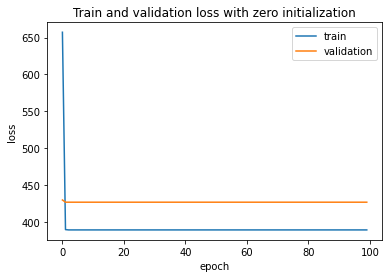

In [269]:
plt.title("Train and validation loss with zero initialization")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss)
plt.plot(validation_loss)
plt.legend(['train', 'validation'])
plt.show()

test our trained network on test data

In [261]:
# Forward pass on test data
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
# Calculate the data loss
y_pred = activation3.output
#calculate RMSE
rmse_zero_weight = np.sqrt(np.mean((y_pred- y_test)**2))
print("root mean squared error for zewo weights = ", rmse_zero_weight)

root mean squared error for zewo weights =  20.06356278660612


### initialize network with random weights

In [262]:
# Create Dense layer with 128 input and 264 output values with tiny random weights
dense1 = Dense( 128 , 264 )
# Create Leaky ReLU activation
activation1 = Activation_Leaky_ReLU()
# Create second Dense layer with 264 input and 128 output values with tiny random weights
dense2 = Dense( 264 , 128)
# Create Leaky ReLU activation 
activation2 = Activation_Leaky_ReLU()
# Create third Dense layer with 128 input and 1 output value with tiny random weights
dense3 = Dense( 128 , 1)
# Create Leaky ReLU activation
activation3 = Activation_Leaky_ReLU()
# Create l2 loss function
loss_function = Loss_L2()
# Create SGD optimizer with momentum
optimizer = Optimizer_SGD( learning_rate = 0.001 , decay = 1e-8 , momentum=0.9)

In [263]:
train_loss_nonzero, val_loss_nonzero = train(X_train, y_train, X_val, y_val, 100, 128)

epoch: 0 , train loss: 584.7891700716367 validation loss: 381.4874307381181 lr: 0.001 
epoch: 10 , train loss: 338.5977333594043 validation loss: 361.9767619879371 lr: 0.00099999990000001 
epoch: 20 , train loss: 336.32531719066816 validation loss: 360.61708740463575 lr: 0.00099999980000004 
epoch: 30 , train loss: 337.11603709615173 validation loss: 363.34260598463123 lr: 0.0009999997000000901 
epoch: 40 , train loss: 334.1218314898475 validation loss: 360.5526007339185 lr: 0.00099999960000016 
epoch: 50 , train loss: 334.7090205780368 validation loss: 377.9486074499764 lr: 0.0009999995000002499 
epoch: 60 , train loss: 339.06348388349045 validation loss: 362.76702161103935 lr: 0.0009999994000003602 
epoch: 70 , train loss: 336.3006859281938 validation loss: 370.3402165113448 lr: 0.00099999930000049 
epoch: 80 , train loss: 340.16046297544244 validation loss: 369.2259960402169 lr: 0.00099999920000064 
epoch: 90 , train loss: 339.2489106597907 validation loss: 378.8035794000186 lr: 0.0

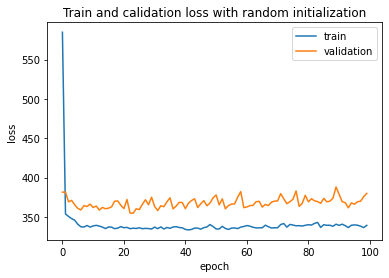

In [264]:
plt.title("Train and calidation loss with random initialization")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_nonzero)
plt.plot(val_loss_nonzero)
plt.legend(['train', 'validation'])
plt.show()

In [271]:
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
# Calculate the data loss
y_pred = activation3.output
#calculate RMSE
rmse_random_weight = np.sqrt(np.mean((y_pred- y_test)**2))
print("root mean squared error for random weights = ", rmse_random_weight)

root mean squared error for random weights =  19.086081057926627


### difference between zerp and random initialization loss

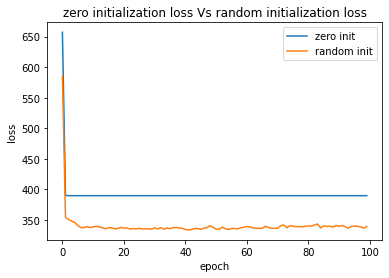

In [266]:
plt.title("zero initialization loss Vs random initialization loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss)
plt.plot(train_loss_nonzero)
plt.legend(['zero init', 'random init'])
plt.show()

## part 2_A: difference between decaying and constant learning rate

### initialize network with constant learning rate

In [272]:
# Create Dense layer with 128 input feature and 264 output values with tiny random weights
dense1 = Dense( 128 , 264 )
# Create Leaky ReLU activation:
activation1 = Activation_Leaky_ReLU()
# Create second Dense layer with 264 input and 128 output values with tiny random weights
dense2 = Dense( 264 , 128)
# Create Leaky ReLU activation:
activation2 = Activation_Leaky_ReLU()
# Create third Dense layer with 128 input features and 1 output value with tiny random weights
dense3 = Dense( 128 , 1)
# Create Leaky ReLU activation:
activation3 = Activation_Leaky_ReLU()
# Create l2 loss function
loss_function = Loss_L2()
# Create SGD optimizer with momentum
optimizer = Optimizer_SGD( learning_rate = 0.001 , decay = 0 , momentum=0.9)

In [273]:
train_loss_constant, val_loss_constant = train(X_train, y_train, X_val,y_val, 100, 128)

epoch: 0 , train loss: 584.4353043267608 validation loss: 381.98229589235353 lr: 0.001 
epoch: 10 , train loss: 337.07282713343955 validation loss: 363.5783314761255 lr: 0.001 
epoch: 20 , train loss: 335.1403356755571 validation loss: 363.3797784698005 lr: 0.001 
epoch: 30 , train loss: 333.07021034854364 validation loss: 372.5242699131562 lr: 0.001 
epoch: 40 , train loss: 335.8314383898102 validation loss: 365.4849265071924 lr: 0.001 
epoch: 50 , train loss: 334.5831007550716 validation loss: 365.9507501879254 lr: 0.001 
epoch: 60 , train loss: 338.54502458123306 validation loss: 376.89966492487844 lr: 0.001 
epoch: 70 , train loss: 336.59368144924764 validation loss: 366.99138944868287 lr: 0.001 
epoch: 80 , train loss: 339.6434026128707 validation loss: 379.48539744833687 lr: 0.001 
epoch: 90 , train loss: 339.95253294962384 validation loss: 367.70272960980003 lr: 0.001 


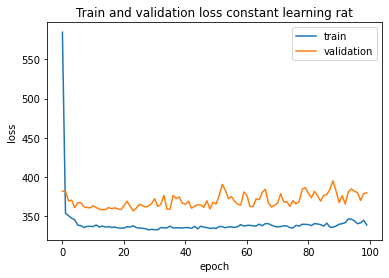

In [274]:
plt.title("Train and validation loss constant learning rat")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_constant)
plt.plot(val_loss_constant)
plt.legend(['train', 'validation'])
plt.show()

test our learned network on test data

In [275]:
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
# Calculate the data loss
y_pred = activation3.output
#calculate RMSE
rmse_constant = np.sqrt(np.mean((y_pred- y_test)**2))
print("root mean squared error for constant learning rate = ", rmse_constant)

root mean squared error for constant learning rate =  19.1114105285656


### initialize network with decaying learning rate (step decaying)

In [276]:
# Create Dense layer with 128 input feature and 264 output values with tiny random weights
dense1 = Dense( 128 , 264 )
# Create Leaky ReLU activation:
activation1 = Activation_Leaky_ReLU()
# Create second Dense layer with 264 input and 128 output values with tiny random weights
dense2 = Dense( 264 , 128)
# Create Leaky ReLU activation:
activation2 = Activation_Leaky_ReLU()
# Create third Dense layer with 128 input and 1 output value
dense3 = Dense( 128 , 1)
# Create Leaky ReLU activation:
activation3 = Activation_Leaky_ReLU()
# Create l2 loss function
loss_function = Loss_L2()
# Create SGD optimizer with momentum
optimizer = Optimizer_SGD( learning_rate = 0.001 , decay = 1e-8 , momentum=0.9)

In [277]:
train_loss_decay, val_loss_decay = train(X_train, y_train, X_val, y_val, 100, 128)

epoch: 0 , train loss: 583.4464909749477 validation loss: 382.5882158419137 lr: 0.001 
epoch: 10 , train loss: 336.09772620646623 validation loss: 366.54763459078936 lr: 0.00099999990000001 
epoch: 20 , train loss: 336.34960459248026 validation loss: 368.2984461511141 lr: 0.00099999980000004 
epoch: 30 , train loss: 336.35423872733037 validation loss: 367.73927007521416 lr: 0.0009999997000000901 
epoch: 40 , train loss: 333.1034520812172 validation loss: 371.28353112773107 lr: 0.00099999960000016 
epoch: 50 , train loss: 335.4167105630697 validation loss: 373.3441183750891 lr: 0.0009999995000002499 
epoch: 60 , train loss: 340.38151696256296 validation loss: 372.50311935332763 lr: 0.0009999994000003602 
epoch: 70 , train loss: 337.5808021492855 validation loss: 387.96114147197864 lr: 0.00099999930000049 
epoch: 80 , train loss: 338.68796089327674 validation loss: 372.1568787578609 lr: 0.00099999920000064 
epoch: 90 , train loss: 343.55364339747257 validation loss: 374.0705079286575 lr:

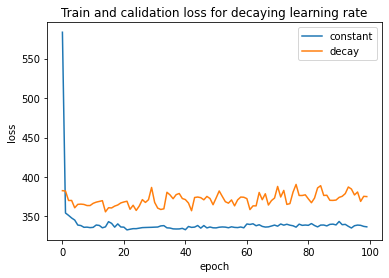

In [278]:
plt.title("Train and calidation loss for decaying learning rate")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_decay)
plt.plot(val_loss_decay)
plt.legend(['constant', 'decay'])
plt.show()

In [279]:
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
# Calculate the data loss
y_pred = activation3.output
#calculate RMSE
rmse_decay = np.sqrt(np.mean((y_pred- y_test)**2))
print("root mean squared error for decaying learning rate = ", rmse_decay)

root mean squared error for decaying learning rate =  18.970112476902187


### difference between constant and decaying learning rate

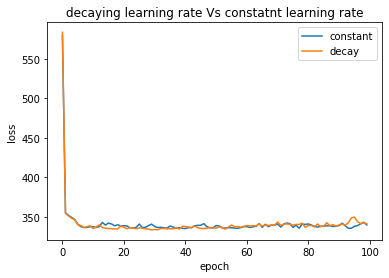

In [80]:
plt.title("decaying learning rate Vs constatnt learning rate")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_constant)
plt.plot(train_loss_decay)
plt.legend(['constant', 'decay'])
plt.show()

# Part 2 : calssifying race


### softmax activation

In [280]:
# Softmax activation
class Activation_Softmax :
# Forward pass
  def forward ( self , inputs ):
    """
    first we get unnormalized probabilities
    and then normalize them for each sample
    """
    self.inputs = inputs
    exp_values = np.exp(inputs - np.max(inputs, axis = 1 ,keepdims = True ))
    probabilities = exp_values / np.sum(exp_values, axis = 1 , keepdims = True )
    self.output = probabilities

  # Backward pass
  def backward ( self , dvalues ):
    """
    1. Create uninitialized array
    2. Enumerate outputs and gradients 
    for each output and gradient
      Flatten output array  
      Calculate Jacobian matrix of the output
      Calculate sample-wise gradient and add it to the array of sample gradients
    """
    self.dinputs = np.empty_like(dvalues)
    for index, (output,dvalue) in enumerate ( zip (self.output, dvalues)):
      output = output.reshape( - 1 , 1 )
      j_matrix = np.diagflat(output) - np.dot(output, output.T)
      self.dinputs[index] = np.dot(j_matrix, dvalue)

### negative loglikelihood loss

In [281]:
class Loss_negative_log( Loss ):
  # Forward pass
  def forward ( self , y_pred , y_true ):
    sample_len = len (y_pred)
    # Clip data to prevent division by 0 error in log
    y_pred_clipped = np.clip(y_pred, 1e-7 , 1 - 1e-7 )
    #if we have 2 classes 
    if len (y_true.shape) == 1 :
      correct_conf = y_pred_clipped[range (sample_len),y_true]
    # if we have multi class mask values - only for one-hot encoded labels 
    elif len (y_true.shape) == 2 :
      correct_conf = np.sum(y_pred_clipped * y_true,axis = 1)
    # calculate negative log likelihood
    negative_log_likelihoods = - np.log(correct_conf)
    return negative_log_likelihoods

    # Backward pass
  def backward ( self , dvalues , y_true ):
  # Number of samples
    sample_len = len (dvalues)
      # Number of labels in every sample
      # We'll use the first sample to count them
    labels = len (dvalues[ 0 ])
    # If labels are sparse, turn them into one-hot vector
    if len (y_true.shape) == 1 :
      y_true = np.eye(labels)[y_true]
    # Calculate gradient
    self.dinputs = - y_true / dvalues
    # Normalize gradient
    self.dinputs = self.dinputs / sample_len

In [298]:
set(df['race'])

{0, 1, 2, 3, 4}

we have 5 classes of race and because of this we put 5 neurons in output layer

encode our classes with one hot encoding

In [299]:
from sklearn.preprocessing import LabelBinarizer

In [300]:
y = LabelBinarizer().fit_transform(df.race)

train test split

In [301]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.24, random_state=42)

In [302]:
y_train.shape

(18015, 5)

train validation split

In [303]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

validation function due to validation after each epoch in trining

In [304]:
def validation(X_train,y_train,batch):
  validation_loss = []
  acc =[]
  batch_size = batch
  data_size = X_train.shape[ 0 ]
  steps = data_size // batch_size
  if steps * batch_size < data_size:
    steps += 1
  for step in range (steps):
    batch_X = X_train[step * batch_size:(step + 1 ) * batch_size]
    batch_y = y_train[step * batch_size:(step + 1 ) * batch_size]
    dense1.forward(batch_X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    # Calculate the data loss
    loss = loss_function.calculate(activation3.output, batch_y)
    validation_loss.append(loss)
    predictions = np.argmax(activation3.output, axis = 1 )
    if len (batch_y.shape) == 2 :
      batch_y = np.argmax(batch_y, axis = 1 )
    accuracy = np.mean(predictions == batch_y)
    acc.append(accuracy)

  return np.mean(validation_loss), np.mean(acc)
    

train function for trainig our network based on our network initialization

In [305]:
def train(X_train,y_train, X_val, y_val,epoch, batch):
  train_loss = []
  validation_loss = []
  validation_acc =[]
  accuracy_list = []
  eps=[]
  epochs = epoch
  batch_size = batch
  data_size = X_train.shape[ 0 ]
  steps = data_size // batch_size
  if steps * batch_size < data_size:
    steps += 1
  # Train in loop
  for epoch in range ( epochs ):
    epoch_loss = []
    acc = []
    for step in range (steps):
      batch_X = X_train[step * batch_size:(step + 1 ) * batch_size]
      batch_y = y_train[step * batch_size:(step + 1 ) * batch_size]
      # Perform a forward pass of our training data through our neural net layers
      dense1.forward(batch_X)
      activation1.forward(dense1.output)
      dense2.forward(activation1.output)
      activation2.forward(dense2.output)
      dense3.forward(activation2.output)
      activation3.forward(dense3.output)
      # Calculate the data loss
      loss = loss_function.calculate(activation3.output, batch_y)
      predictions = np.argmax(activation3.output, axis = 1 )
      if len (batch_y.shape) == 2 :
        batch_y = np.argmax(batch_y, axis = 1 )
      accuracy = np.mean(predictions == batch_y)
      acc.append(accuracy)
      epoch_loss.append(loss)
      #acc += np.sum((predictions == batch_y))
      # Backward pass
      loss_function.backward(activation3.output, batch_y)
      activation3.backward(loss_function.dinputs)
      dense3.backward(activation3.dinputs)
      activation2.backward(dense3.dinputs)
      dense2.backward(activation2.dinputs)
      activation1.backward(dense2.dinputs)
      dense1.backward(activation1.dinputs)
      # Update weights and biases
      optimizer.update(dense1)
      optimizer.update(dense2)
      optimizer.update(dense3)
    e_loss = np.sum(epoch_loss)/steps
    eps.append(epoch_loss)
    e_acc= np.mean(acc)
    accuracy_list.append(e_acc)
    train_loss.append(e_loss)
    val_loss, val_acc = validation(X_val,y_val, batch)
    optimizer.decay_learning_rate()
    optimizer.plus_iteration()
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    if not epoch % 10 :
      print ( f'epoch: {epoch} , ' +
      f'loss: {e_loss} '+
      f'acc: {e_acc} '+
      f'validation_loss: {val_loss} '+
      f'validationacc: {val_acc} '+
      f'lr: {optimizer.current_learning_rate} ' )

  return train_loss, accuracy_list, validation_loss, validation_acc


### initializing network for race classification

In [306]:
# Create Dense layer with 128 input and 264 output 
dense1 = Dense( 128 , 264 )
# Create Leaky ReLU activation
activation1 = Activation_Leaky_ReLU()
# Create second Dense layer with 264 input and 128 output values
dense2 = Dense( 264 , 128)
# Create Leaky ReLU activation
activation2 = Activation_Leaky_ReLU()
# Create third Dense layer with 125 input and 5 output value
dense3 = Dense( 128 , 5)
# Create sofmax activation
activation3 = Activation_Softmax()
# Create negative log loss
loss_function = Loss_negative_log()
# Create SGD optimizer with momentum
optimizer = Optimizer_SGD( learning_rate = 0.001 , decay = 1e-8 , momentum=0.9)

In [307]:
train_loss, train_acc, val_loss, val_acc = train(X_train, y_train, X_val, y_val, 100, 128)

epoch: 0 , loss: 1.5764468565576872 acc: 0.42010768874478926 validation_loss: 1.5386963014389035 validationacc: 0.44 lr: 0.001 
epoch: 10 , loss: 1.3018448741540711 acc: 0.4871924212598425 validation_loss: 1.2743864546532617 validationacc: 0.5122916666666667 lr: 0.00099999990000001 
epoch: 20 , loss: 1.2696078970369693 acc: 0.5033095472440945 validation_loss: 1.2560723992788474 validationacc: 0.5175 lr: 0.00099999980000004 
epoch: 30 , loss: 1.2500814870320158 acc: 0.5076786127836961 validation_loss: 1.235628816642406 validationacc: 0.5309375 lr: 0.0009999997000000901 
epoch: 40 , loss: 1.2421065120985293 acc: 0.5117994441871236 validation_loss: 1.2298315136747477 validationacc: 0.5417708333333333 lr: 0.00099999960000016 
epoch: 50 , loss: 1.2398193675273639 acc: 0.5124146016674387 validation_loss: 1.2308523521110886 validationacc: 0.5396875 lr: 0.0009999995000002499 
epoch: 60 , loss: 1.238813981600936 acc: 0.5146291685965725 validation_loss: 1.2332258394965787 validationacc: 0.538645

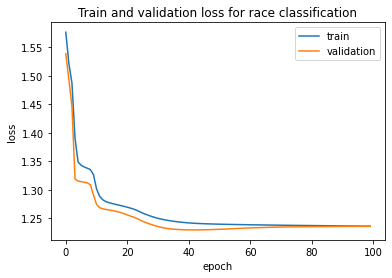

In [308]:
plt.title("Train and validation loss for race classification")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'validation'])
plt.show()

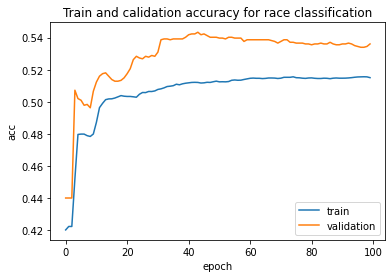

In [309]:
plt.title("Train and calidation accuracy for race classification")
plt.ylabel("acc")
plt.xlabel("epoch")
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'validation'])
plt.show()

In [117]:
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
# Calculate the data loss
test_loss = loss_function.calculate(activation3.output, y_test)
predictions = np.argmax(activation3.output, axis = 1 )
if len (y_test.shape) == 2 :
  y_test = np.argmax(y_test, axis = 1 )
test_accuracy = np.mean(predictions == y_test)
print("aacuracy of reca classification model on test data", test_accuracy)

aacuracy of reca classification model on test data 0.5066783831282953


# part 3: logistic Regression

### sigmoid activation function

In [310]:
# Sigmoid activation
class Activation_Sigmoid :
  # Forward pass
  def forward ( self , inputs ):
    self.inputs = inputs
    self.output = 1 / ( 1 + np.exp( - inputs))
  # Backward pass
  def backward ( self , dvalues ):
    self.dinputs = dvalues * ( 1 - self.output) * self.output

### logistic loss

In [311]:
# Binary cross-entropy loss
class Loss_logistic ( Loss ):
# Forward pass
  def forward ( self , y_pred , y_true ):
    #  Clip data to prevent division by 0 error in log
    y_pred_clipped = np.clip(y_pred, 1e-7 , 1 - 1e-7 )
    # Calculate sample-wise loss
    sample_losses = - (y_true * np.log(y_pred_clipped) + ( 1 - y_true) * np.log( 1 - y_pred_clipped))
    sample_losses = np.mean(sample_losses, axis =- 1 )
    # Return losses
    return sample_losses

  # Backward pass
  def backward ( self , dvalues , y_true ):
    # Number of samples
    sample_len = len (dvalues)
    output = len (dvalues[ 0 ])
    # Clip data to prevent division by 0 error in log
    clipped_dvalue = np.clip(dvalues, 1e-7 , 1 - 1e-7 )
    # Calculate gradient
    self.dinputs = - (y_true / clipped_dvalue - ( 1 - y_true) / ( 1 - clipped_dvalue)) / output
    # Normalize gradient
    self.dinputs = self.dinputs / sample_len

validation function for validation after each epoch of training

In [312]:
def validation(X_train,y_train,batch):
  validation_loss = []
  acc =[]
  batch_size = batch
  data_size = X_train.shape[ 0 ]
  steps = data_size // batch_size
  if steps * batch_size < data_size:
    steps += 1
  for step in range (steps):
    batch_X = X_train[step * batch_size:(step + 1 ) * batch_size]
    batch_y = y_train[step * batch_size:(step + 1 ) * batch_size]
    dense1.forward(batch_X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    # Calculate the data loss
    loss = loss_function.calculate(activation3.output, batch_y)
    validation_loss.append(loss)
    predictions = (activation3.output> 0.5 ) * 1
    accuracy = np.mean(predictions == batch_y)
    acc.append(accuracy)

  return np.mean(validation_loss), np.mean(acc)
    

train function for training our model in given epochs based on initilized network

In [314]:
def train(X_train,y_train, X_val, y_val,epoch, batch):
  train_loss = []
  validation_loss = []
  validation_acc =[]
  accuracy_list = []
  eps=[]
  epochs = epoch
  batch_size = batch
  data_size = X_train.shape[ 0 ]
  steps = data_size // batch_size
  if steps * batch_size < data_size:
    steps += 1
  # Train in loop
  for epoch in range ( epochs ):
    epoch_loss = []
    acc = []
    for step in range (steps):
      batch_X = X_train[step * batch_size:(step + 1 ) * batch_size]
      batch_y = y_train[step * batch_size:(step + 1 ) * batch_size]
      # Perform a forward pass of our training data through our neural net layers
      dense1.forward(batch_X)
      activation1.forward(dense1.output)
      dense2.forward(activation1.output)
      activation2.forward(dense2.output)
      dense3.forward(activation2.output)
      activation3.forward(dense3.output)
      # Calculate the data loss
      loss = loss_function.calculate(activation3.output, batch_y)
      predictions = (activation3.output> 0.5 ) * 1
      accuracy = np.mean(predictions == batch_y)
      acc.append(accuracy)
      epoch_loss.append(loss)
      #acc += np.sum((predictions == batch_y))
      # Backward pass
      loss_function.backward(activation3.output, batch_y)
      activation3.backward(loss_function.dinputs)
      dense3.backward(activation3.dinputs)
      activation2.backward(dense3.dinputs)
      dense2.backward(activation2.dinputs)
      activation1.backward(dense2.dinputs)
      dense1.backward(activation1.dinputs)
      # Update weights and biases
      optimizer.update(dense1)
      optimizer.update(dense2)
      optimizer.update(dense3)
    e_loss = np.sum(epoch_loss)/steps
    eps.append(epoch_loss)
    e_acc= np.mean(acc)
    accuracy_list.append(e_acc)
    train_loss.append(e_loss)
    val_loss, val_acc = validation(X_val,y_val, batch)
    optimizer.decay_learning_rate()
    optimizer.plus_iteration()
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    if not epoch % 10 :
      print ( f'epoch: {epoch} , ' +
      f'loss: {e_loss} '+
      f'acc: {e_acc} '+
      f'validation_loss: {val_loss} '+
      f'validationacc: {val_acc} '+
      f'lr: {optimizer.current_learning_rate} ' )

  return train_loss, accuracy_list, validation_loss, validation_acc


this time y or our labes is gender column of our data frame

In [315]:
y = df.gender.values.reshape(-1,1)

train test split

In [316]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.24, random_state=42)

In [317]:
y_train

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

train validation split

In [318]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

### initialize our network for logistic regression (gender classification)

In [321]:
# Create Dense layer with 128 input feature and 264 output values
dense1 = Dense( 128 , 264 )
# Create Leaky ReLU activation:
activation1 = Activation_Leaky_ReLU()
# Create second Dense layer with 128 input and 128 output values
dense2 = Dense( 264 , 128)
# Create Leaky ReLU activation:
activation2 = Activation_Leaky_ReLU()
# Create third Dense layer with 128 input and 1 output value
dense3 = Dense( 128 , 1)
# Create sigmoid activation
activation3 = Activation_Sigmoid()
# Create logistic loss function
loss_function = Loss_logistic()
# Create SGD optimizer with momentum
optimizer = Optimizer_SGD( learning_rate = 0.001 , decay = 1e-8 , momentum=0.9)

In [322]:
train_loss, train_acc, val_loss, val_acc = train(X_train, y_train, X_val, y_val, 100, 128)

epoch: 0 , loss: 0.6928794663925737 acc: 0.5245925486336266 validation_loss: 0.6933542254955547 validationacc: 0.494375 lr: 0.001 
epoch: 10 , loss: 0.5965585854393032 acc: 0.6931167496526169 validation_loss: 0.597083092626269 validationacc: 0.6882291666666667 lr: 0.00099999990000001 
epoch: 20 , loss: 0.5937630478828986 acc: 0.6903485409911996 validation_loss: 0.5981272563317854 validationacc: 0.6892708333333334 lr: 0.00099999980000004 
epoch: 30 , loss: 0.592798680934181 acc: 0.6900720819823992 validation_loss: 0.5982458463536382 validationacc: 0.6908333333333334 lr: 0.0009999997000000901 
epoch: 40 , loss: 0.5923038483120546 acc: 0.6903796607225567 validation_loss: 0.5982356146668121 validationacc: 0.6908333333333334 lr: 0.00099999960000016 
epoch: 50 , loss: 0.5920518159457204 acc: 0.6909948182028717 validation_loss: 0.5981539502564543 validationacc: 0.6892708333333334 lr: 0.0009999995000002499 
epoch: 60 , loss: 0.5918822255257657 acc: 0.6903796607225567 validation_loss: 0.5980297

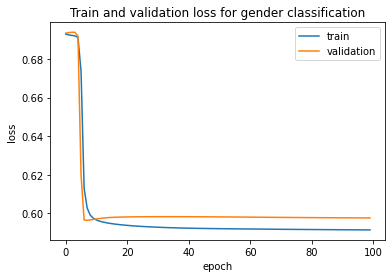

In [323]:
plt.title("Train and validation loss for gender classification")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'validation'])
plt.show()

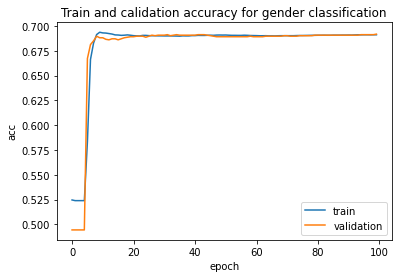

In [324]:
plt.title("Train and calidation accuracy for gender classification")
plt.ylabel("acc")
plt.xlabel("epoch")
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'validation'])
plt.show()

In [327]:
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
# Calculate the data loss
test_loss = loss_function.calculate(activation3.output, y_test)
predictions = (activation3.output> 0.5 ) * 1
test_accuracy = np.mean(predictions == y_test)
print("aacuracy of gender classification model on test data",test_accuracy)

aacuracy of gender classification model on test data 0.6808435852372583
